# E-Commerce Sales Analysis and Forecasting

In [99]:
import kaggle
import pandas as pd
import zipfile
import chardet
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [100]:
!kaggle datasets download -d carrie1/ecommerce-data

Dataset URL: https://www.kaggle.com/datasets/carrie1/ecommerce-data
License(s): unknown
ecommerce-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [101]:
zipfile_name = 'ecommerce-data.zip'
with zipfile.ZipFile(zipfile_name, 'r') as file:
    file.extractall()

sales = pd.read_csv('data.csv', encoding='latin1')
sales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Data Cleaning and Exploration

In [102]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [103]:
sales.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [104]:
sales[sales.Description.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom


Note: there are 135,080 sales that are missing customerIDs! It would be worth investigating how such sales could be recorded without a customerID. There are also 1,454 items without a description and it seems that if the description is missing, the customerID is missing as well. 

In [105]:
description_counts = sales['Description'].value_counts()
description_counts.tail(50)

Description
mouldy                                 1
S/4 BLACK DISCO PARTITION PANEL        1
RUBY GLASS NECKLACE 42"                1
wrong barcode                          1
barcode problem                        1
 I LOVE LONDON MINI RUCKSACK           1
SET 10 CARDS 12 DAYS OF XMAS 17059     1
ZINC PLANT POT HOLDER                  1
POLYESTER FILLER PAD 60x40cm           1
LASER CUT MULTI STRAND NECKLACE        1
72 CAKE CASES VINTAGE CHRISTMAS        1
HAYNES CAMPER SHOULDER BAG             1
PINK FLOCK PHOTO FRAME                 1
damages/showroom etc                   1
samples                                1
damages/credits from ASOS.             1
4 GOLD FLOCK CHRISTMAS BALLS           1
mailout                                1
wrong code                             1
FOOD COVER WITH BEADS , SET 2 SIZES    1
Not rcvd in 10/11/2010 delivery        1
Thrown away-rusty                      1
CRYSTAL CHANDELIER T-LIGHT HOLDER      1
IVORY PANTRY HANGING LAMP              1
BREA

Looking at some of the single items sold, I saw that this data included items marked out of stock such as damaged items. It seems as though this retailer does not separate valid customer transactions from these types of special transactions. My recommendation would be to use a special code for these types of transactions so that they are easily seperable from customer transactions. For now, we will remove all the NaN values for cleaning.

In [106]:
sales = sales.dropna()
sales.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [107]:
print(sales.StockCode.nunique())
print(sales.Description.nunique())

3684
3896


We see that sometimes stock code and description does not match. We have more descriptions than we have stock codes.

In [108]:
sales.groupby("StockCode").Description.nunique().sort_values(ascending=False).iloc[0:10]

StockCode
23236     4
23196     4
22776     3
23203     3
17107D    3
23413     3
23231     3
23396     3
23240     3
23126     3
Name: Description, dtype: int64

We see that we have stockcodes that contain multiple descriptions. 

In [109]:
sales.loc[sales.StockCode == "17107D"].Description.value_counts()

Description
FLOWER FAIRY,5 SUMMER B'DRAW LINERS    25
FLOWER FAIRY 5 DRAWER LINERS           21
FLOWER FAIRY 5 SUMMER DRAW LINERS       1
Name: count, dtype: int64

Based off this example we can see that even though they have multiple descriptions they are still the same item most likely. The only difference is typos/punctuation probably due to human error.

In [110]:
sales.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [111]:
#change invoicedate to datetime type
sales['InvoiceDate'] = pd.to_datetime(sales['InvoiceDate'], cache=True)

In [112]:
sales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [113]:
print(sales.InvoiceDate.max() - sales.InvoiceDate.min())
print("Datafile starts with timepoint {}".format(sales.InvoiceDate.min()))
print("Datafile ends with timepoint {}".format(sales.InvoiceDate.max()))

373 days 04:24:00
Datafile starts with timepoint 2010-12-01 08:26:00
Datafile ends with timepoint 2011-12-09 12:50:00


In [114]:
sales.InvoiceNo.nunique()

22190

In [115]:
sales.CustomerID.nunique()

4372

In [116]:
sales['Country'].value_counts()

Country
United Kingdom          361878
Germany                   9495
France                    8491
EIRE                      7485
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1480
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     250
Unspecified                244
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45


In [117]:
sales.CustomerID.describe()

count    406829.000000
mean      15287.690570
std        1713.600303
min       12346.000000
25%       13953.000000
50%       15152.000000
75%       16791.000000
max       18287.000000
Name: CustomerID, dtype: float64

In [118]:
sales['CustomerID'] = sales['CustomerID'].astype(int)
sales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [119]:
sales.UnitPrice.describe()

count    406829.000000
mean          3.460471
std          69.315162
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max       38970.000000
Name: UnitPrice, dtype: float64

In [120]:
sales.loc[sales.UnitPrice == 0].sort_values(by="Quantity", ascending=False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256,United Kingdom
298054,562973,23157,SET OF 6 NATIVITY MAGNETS,240,2011-08-11 11:42:00,0.0,14911,EIRE
436428,574138,23234,BISCUIT TIN VINTAGE CHRISTMAS,216,2011-11-03 11:26:00,0.0,12415,Australia
314746,564651,23268,SET OF 2 CERAMIC CHRISTMAS REINDEER,192,2011-08-26 14:19:00,0.0,14646,Netherlands
314747,564651,22955,36 FOIL STAR CAKE CASES,144,2011-08-26 14:19:00,0.0,14646,Netherlands


it appears that there are some invoices that have unitprice of 0 but large quantities. It is unclear what these transactions are. Since these are not traditional customer-retailer transactions, I will remove them.

In [121]:
sales = sales[sales.UnitPrice != 0]
sales.UnitPrice.describe()

count    406789.000000
mean          3.460811
std          69.318561
min           0.001000
25%           1.250000
50%           1.950000
75%           3.750000
max       38970.000000
Name: UnitPrice, dtype: float64

Now the minimum unit price is .001 and 38970 is the most expensive. 

In [122]:
sales.loc[sales.UnitPrice == 38970].sort_values(by="Quantity", ascending=False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
222681,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.0,15098,United Kingdom


We see another problem here... negative quantities!!! This is an expensive unit price with a negative quantity. I noticed that the invoice number is different than the others. It starts with a C. Let's see all the invoice numbers that start with a C.

In [123]:
sales.loc[sales.InvoiceNo.str.startswith(('C'))]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom


It looks like all of these invoices have negative quantities. These must be refunds or something similar. We shall remove these.

In [124]:
sales = sales[-sales.InvoiceNo.str.startswith(('C'))]
sales.loc[sales.InvoiceNo.str.startswith(('C'))]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [125]:
sales.sort_values(by="UnitPrice", ascending=False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom
422351,573077,M,Manual,1,2011-10-27 14:13:00,4161.06,12536,France
422376,573080,M,Manual,1,2011-10-27 14:20:00,4161.06,12536,France
406406,571751,M,Manual,1,2011-10-19 11:18:00,3949.32,12744,Singapore
374542,569382,M,Manual,1,2011-10-03 16:44:00,3155.95,15502,United Kingdom


## Data Visualization

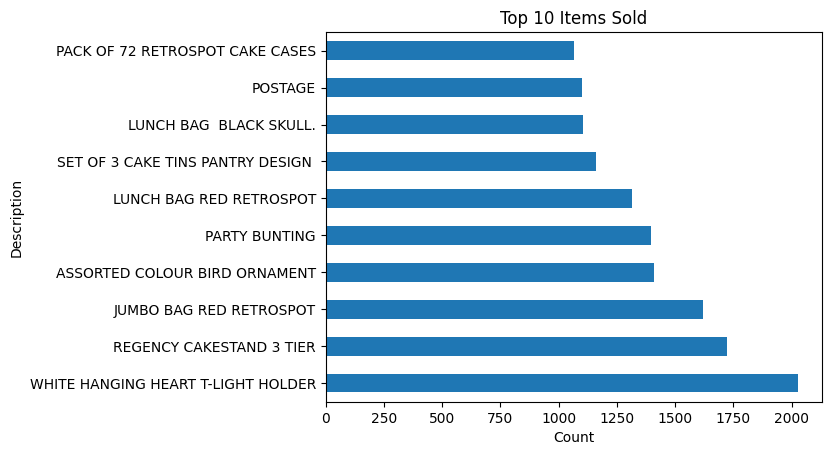

In [126]:
description_counts = sales['Description'].value_counts()
description_counts.head(10).plot(kind='barh')
plt.title('Top 10 Items Sold')
plt.xlabel('Count')
plt.ylabel('Description')
plt.show()

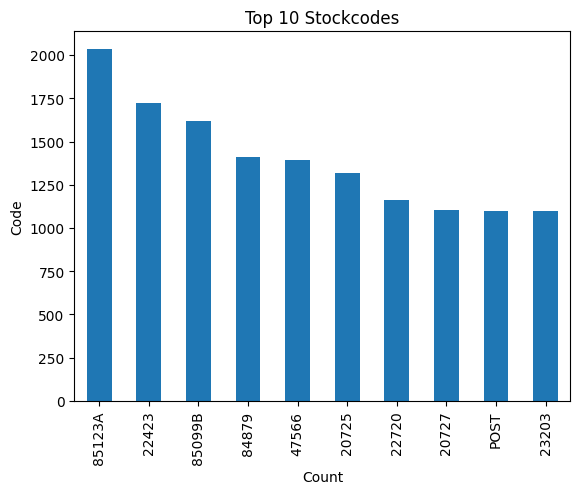

In [127]:
stockcode_counts = sales.StockCode.value_counts()
stockcode_counts.head(10).plot(kind='bar')
plt.title('Top 10 Stockcodes')
plt.xlabel('Count')
plt.ylabel('Code')
plt.show()

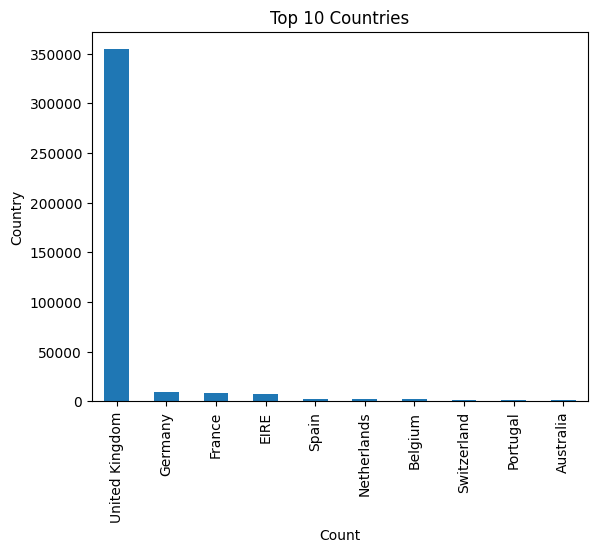

In [128]:
country_counts = sales.Country.value_counts()
country_counts.head(10).plot(kind='bar')
plt.title('Top 10 Countries')
plt.xlabel('Count')
plt.ylabel('Country')
plt.show()

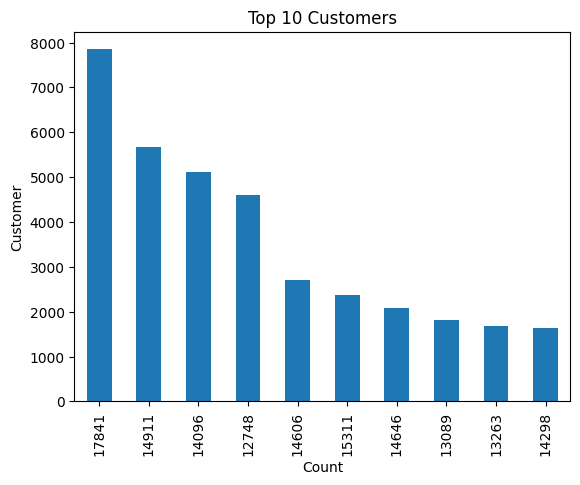

In [129]:
customer_counts = sales.CustomerID.value_counts()
customer_counts.head(10).plot(kind='bar')
plt.title('Top 10 Customers')
plt.xlabel('Count')
plt.ylabel('Customer')
plt.show()

In [130]:
#create a new column for total sales for each invoice
sales['TotalSales'] = sales['Quantity'] * sales['UnitPrice']
sales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [131]:
sales.TotalSales.describe()

count    397884.000000
mean         22.397000
std         309.071041
min           0.001000
25%           4.680000
50%          11.800000
75%          19.800000
max      168469.600000
Name: TotalSales, dtype: float64

In [138]:
# Aggregate sales by month using 'ME' for Month-end
monthly_sales = sales.resample('ME', on='InvoiceDate')['TotalSales'].sum()
monthly_sales.head()

InvoiceDate
2010-12-31    572713.890
2011-01-31    569445.040
2011-02-28    447137.350
2011-03-31    595500.760
2011-04-30    469200.361
Freq: ME, Name: TotalSales, dtype: float64

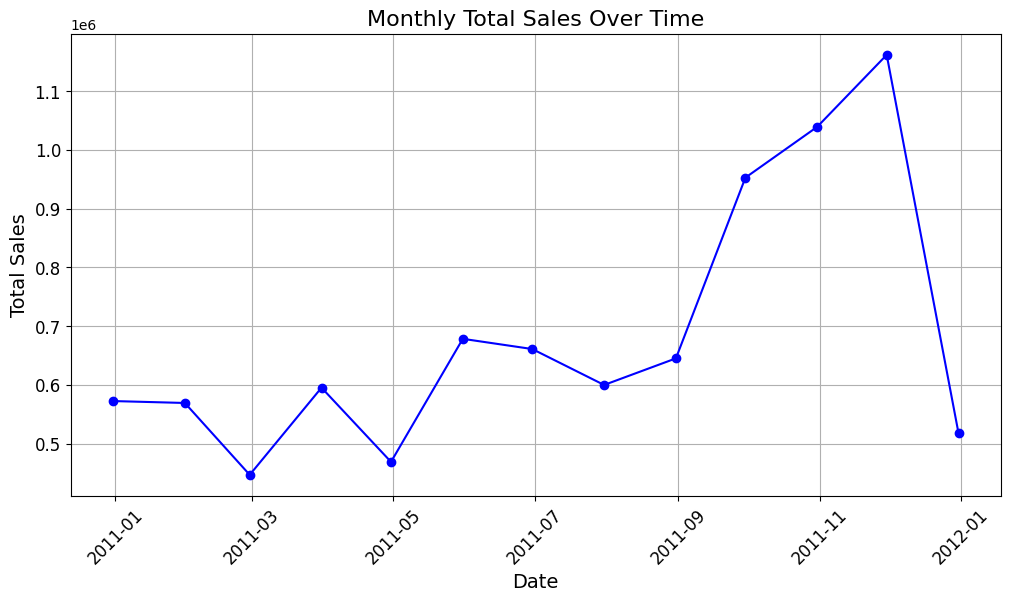

In [139]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales.values, marker='o', linestyle='-', color='b')
plt.title('Monthly Total Sales Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

## Forecasting Sales

In [142]:
# Forecasting
from prophet import Prophet

# Prepare data for Prophet
sales_data = sales.groupby('InvoiceDate').sum()['TotalSales'].reset_index()
sales_data.columns = ['ds', 'y']

# Initialize and fit Prophet model
model = Prophet()
model.fit(sales_data)

# Make future dataframe and predict
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)

10:12:02 - cmdstanpy - INFO - Chain [1] start processing
10:12:04 - cmdstanpy - INFO - Chain [1] done processing


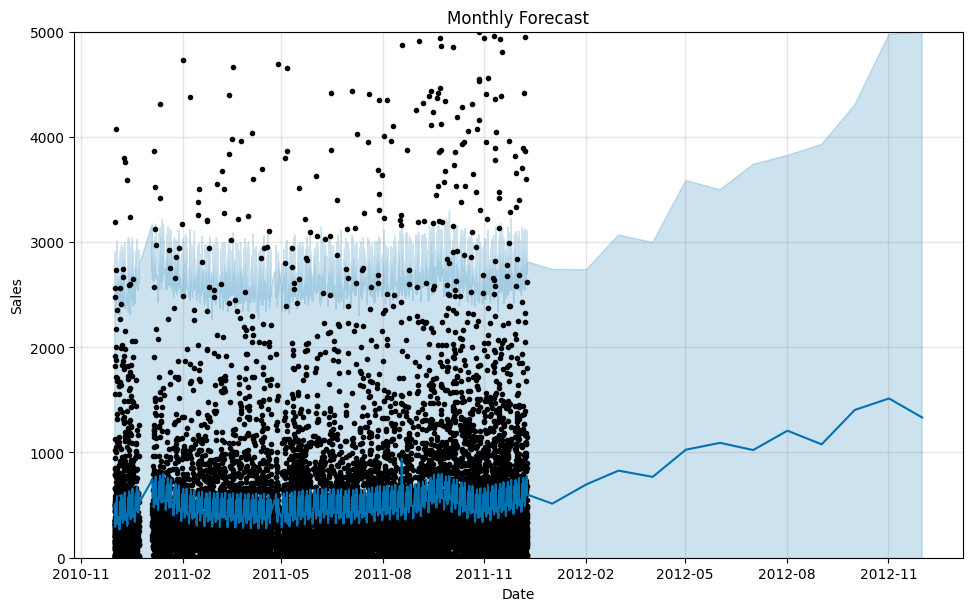

In [145]:
# Plot forecast
model.plot(forecast)
plt.title('Monthly Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
# Set y-axis limits
plt.ylim(0, 5000)  # Set the y-axis limit to 0 and 25000
plt.show()
plt.show()

Here we see that sales stay steady and are projected to increase over time. The black dots represent the current data, the blue line represents projected data.

## Clustering

In [146]:
sales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [147]:
features = sales.groupby('CustomerID').agg({'TotalSales': 'sum', 'InvoiceNo': 'nunique'}).reset_index()
features.columns = ['CustomerID', 'total_purchase', 'num_orders']

In [148]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
features['customer_segment'] = kmeans.fit_predict(features[['total_purchase', 'num_orders']])


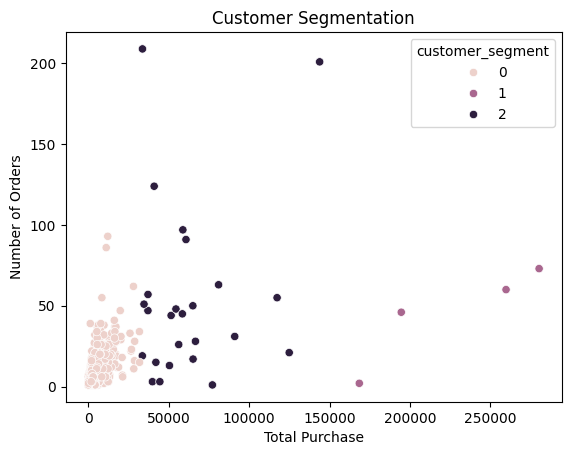

In [149]:
sns.scatterplot(data=features, x='total_purchase', y='num_orders', hue='customer_segment')
plt.title('Customer Segmentation')
plt.xlabel('Total Purchase')
plt.ylabel('Number of Orders')
plt.show()

Customer segementation is valuable to gain insights on customer spending trends. The above graph shows the groups of customers that have similar spending trends in terms of the amount they spend and number of orders. The retailer can develop targeted marketing stragegies or promotions for each customer segment based on these insights. It seems that most customers have under 50 orders and have a total purchase price of under 50,000. Based on this information the retailer can allocate resources on keeping these customers happy and continuously purchasing their products. 